# About Dataset

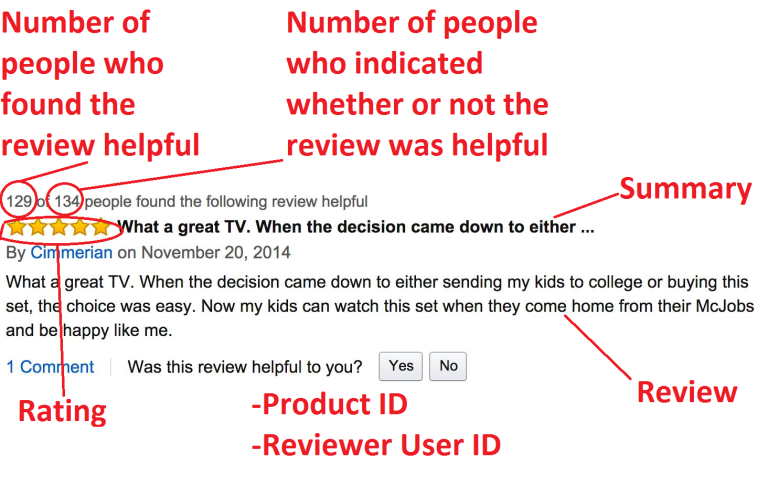

In [22]:
from PIL import Image
img1 = Image.open("AmazonReview.png")
img1

#### The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

#### Number of reviews: 568,454
#### Number of users: 256,059
#### Number of products: 74,258
#### Timespan: Oct 1999 - Oct 2012
#### Number of Attributes/Columns in data: 10

# Attribute/Column Information

##### 1. Id
##### 2. ProductId - unique identifier for the product
##### 3. UserId - unqiue identifier for the user
##### 4. ProfileName
##### 5. HelpfulnessNumerator - number of users who found the review helpful
##### 6. HelpfulnessDenominator - number of users who indicated whether they found the * review helpful or not
##### 7. Score - rating between 1 and 5
##### 8. Time - timestamp for the review
##### 9. Summary - brief summary of the review
##### 10. Text - text of the review

# Problem Statement
##### Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

In [23]:
# import libraraies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [24]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_auc_score
from bs4 import BeautifulSoup
import re

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import pickle
import seaborn as sns
from tqdm import tqdm
import os

In [25]:
# read dataset

review = pd.read_csv("Reviews.csv")
review.head(2)

Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...

In [26]:
# Columns of dataset

review.columns


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [27]:
# shape of dataset

review.shape

# Observation: no. of rows = 568454 && no. of columns = 10

(568454, 10)

In [28]:
# checking if there is any null values in dataset

review.info()

# Observation: As we can see there is no null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [29]:
# Checking either dataset is balance or not
# Checking the number of datapoints for each score

review["Score"].value_counts()

# Observation: 
# 1. least rating is "1" and Highest rating is "5"
# 2. Maximum number of datapoint is for "5" - is positive review

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [30]:
# Checking if there is any duplicate value in dataset

duplicate_reviews = review[review.duplicated(subset=['UserId','ProfileName','Time','Text'],keep=False)]
duplicate_reviews.shape

(232415, 10)

In [31]:
duplicate_reviews[duplicate_reviews["UserId"] == "A395BORC6FGVXV"]

Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
3            4  B000UA0QIQ  A395BORC6FGVXV        Karl                     3   
136303  136304  B002Y7526Y  A395BORC6FGVXV        Karl                     3   
544172  544173  B000U9WZ54  A395BORC6FGVXV        Karl                     3   

        HelpfulnessDenominator  Score        Time         Summary  \
3                            3      2  1307923200  Cough Medicine   
136303                       3      2  1307923200  Cough Medicine   
544172                       3      2  1307923200  Cough Medicine   

                                                     Text  
3       If you are looking for the secret ingredient i...  
136303  If you are looking for the secret ingredient i...  
544172  If you are looking for the secret ingredient i...

In [32]:
# Remove duplicate reviews - keep first entry and rest will be deleted
# df.duplicated(subset = [column name], keep = "first/Second/False")
# df.drop_duplicates(subset = ["column names"], keep = "first/Second/False")
# keep = "first" - will keep the first review and rest of the duplicate value will be dropped
# Keep = "second" - will keep the second review and rest of the duplicate value will be dropped
# keep = false - will drop all duplicates values

reviews = review.drop_duplicates(subset=['UserId','ProfileName','Time','Text'],keep="first", inplace = False)
reviews.shape

(393933, 10)

In [33]:
reviews.head(2)

Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...

In [34]:
#Checking to see how much % of data still remains
print(f'Remaining data is {((reviews.shape[0]*1.0)/(review.shape[0]*1.0))*100}')

Remaining data is 69.29901100176971


# Explore Dataset

In [35]:
# step1: Distribution of review - I first looked at the distribution of ratings among all of the reviews.
reviews.Score.value_counts(1)

# Observation: 5-star reviews constitute a large proportion (63.7%) of all reviews. 
# The next most prevalent rating is 4-stars(14.2%), followed by 1-star (9.2%), 3-star (7.5%), 
# and finally 2-star reviews (5.2%)

5    0.637068
4    0.142395
1    0.092163
3    0.075569
2    0.052806
Name: Score, dtype: float64

In [36]:
# Score = 1 --> if score>3 (+ve review)
# Score = 0 --> of score<3 (-ve review)
score = reviews['Score'].apply(lambda x: 1 if x > 3 else 0)
reviews['Score'] = score
reviews.head(3)


C:\Users\HP\AppData\Local\Temp\ipykernel_11344\775092958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['Score'] = score


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [37]:
pos_rev = reviews.Text[reviews["Score"] == 1]

In [38]:
from wordcloud import WordCloud, STOPWORDS

review_words = ""
stopwords = set(STOPWORDS)
for review in tqdm(pos_rev):
    review = str(review)
    token = review.split()
    for idx in range(0,len(token)):
        token[idx] = token[idx].lower()
    review_words += " ".join(token)+" " # +" " include all words, alphabets and symbols present in review 


100%|█████████████████████████████████████████████████████████████████████████| 307056/307056 [11:27<00:00, 446.61it/s]


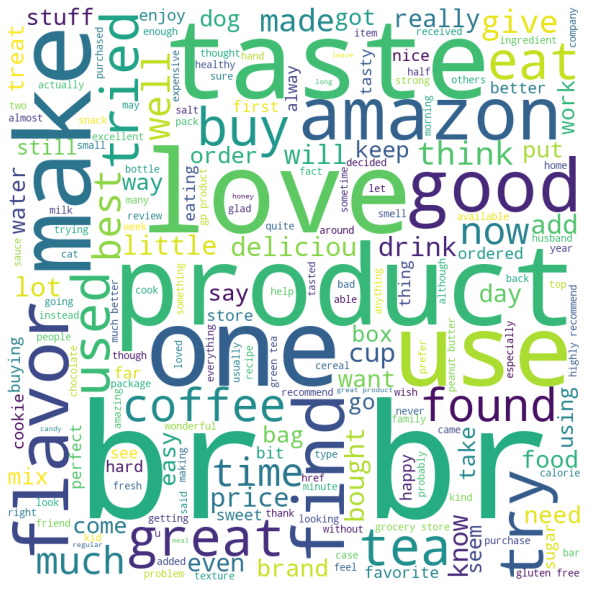

In [39]:
word_cloud = WordCloud(width = 800, height = 800, background_color = "white", stopwords = stopwords, min_font_size = 10).generate(review_words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [40]:
neg_rev = reviews.Text[reviews["Score"] == 0]

In [41]:
negative_review = ""
for review in tqdm(neg_rev):
    review = str(review)
    token = review.split()
    for i in range(0,len(token)):
        token[i] = token[i].lower()
    negative_review += " ".join(token)+" "


100%|██████████████████████████████████████████████████████████████████████████| 86877/86877 [01:12<00:00, 1200.80it/s]


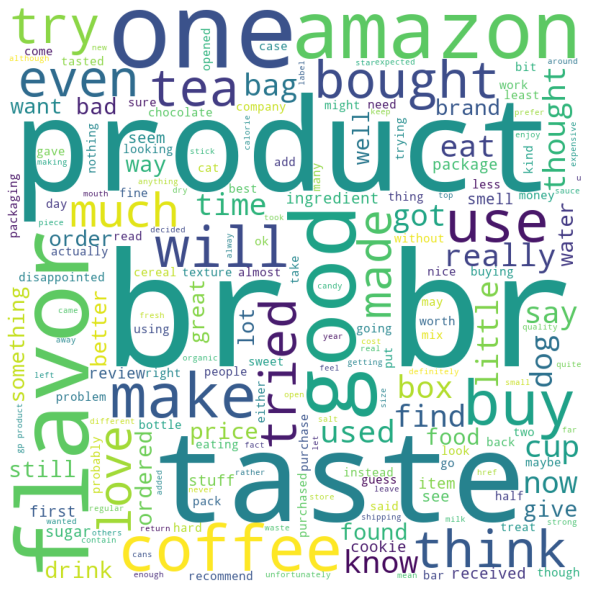

In [42]:
negative_wordcloud = WordCloud(width = 800, height = 800, background_color = "white", stopwords = stopwords, min_font_size = 10).generate(negative_review)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(negative_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Analysis of Review over time

In [43]:
# Convert Time into date
reviews["Date"] = pd.to_datetime(reviews["Time"],unit = "s")
reviews.head(2)
# Create a new dataframe   which comprises of date, text and score
df = reviews[["Date","Text","Score"]]

# Consider only Year and month
df["Date"] = df.Date.dt.strftime("%Y-%m")
df.head(2)

C:\Users\HP\AppData\Local\Temp\ipykernel_11344\2933401371.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = df.Date.dt.strftime("%Y-%m")


Date                                               Text  Score
0  2011-04  I have bought several of the Vitality canned d...      1
1  2012-09  Product arrived labeled as Jumbo Salted Peanut...      0

In [44]:
# Sort df by date
df = df.sort_values(by = ["Date"]).reset_index(drop = True)

# Get distinct dataframe as per score
df_1 = df[df["Score"] == 1]
df_0 = df[df["Score"] == 0]

# Groupby dataframe w.r.t date and score
df_1 = df_1.groupby('Date')['Score'].count().reset_index()
df_1.head(2)

Date  Score
0  1999-10      2
1  1999-12      2

In [45]:
df_0 = df_0.groupby("Date")["Score"].count().reset_index()
df_0.head(2)

Date  Score
0  2000-01      1
1  2001-05      1

In [46]:
# fig.update_layout(
#     title="Plot Title",
#     xaxis_title="X Axis Title",
#     yaxis_title="Y Axis Title",
#     legend_title="Legend Title",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="RebeccaPurple"
#     )
# )

import plotly.graph_objects as go
from plotly.offline import iplot

# dict for the dataframes and their names
dfs = {"Positive_Review" : df_1, "Negative_Review": df_0}

# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i]["Date"],
                                   y = dfs[i]["Score"],
                                   name = i))



fig.update_layout(
    title="Review Trend from 2000 - 2012",
    xaxis_title="Date",
    yaxis_title="Number of reviews")
    
fig.show()

#### Observation:
##### 1. From 2000  to late 2005 the positive and negative reviews remain constant to 0.
##### 2. From late 2005 - 2012 there is gradually increase in reviews.
##### 3. Positive reviews are increasing faster than negative reviews.
##### 4. Reason: Lack of awareness among the people about online food shopping.
##### 5. May be people are less active in providing reviews.

# Analysis of Score (Target Variable)

In [47]:
reviews["Score"].value_counts()

1    307056
0     86877
Name: Score, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



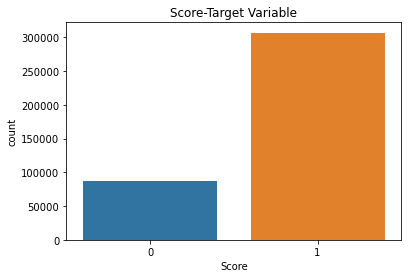

In [48]:
sns.countplot(reviews["Score"])
plt.title("Score-Target Variable")
plt.show()

### Observation:
#### 1. Score - is an imbalance dataset
#### 2. We cannot use accuracy as performance matrics because "Score" is imbalanced.
#### 3. We can use AUC-ROC Curve as performance metrics.
#### 4. AUC is the area under ROC curve.It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.

# Analysis on ProductId and UserId

In [49]:
# we will see the products bought by each customer

purchase = reviews[["ProductId","UserId"]].groupby(by="UserId").count().reset_index()
purchase.columns = ["User_id","No. of product purchased"]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



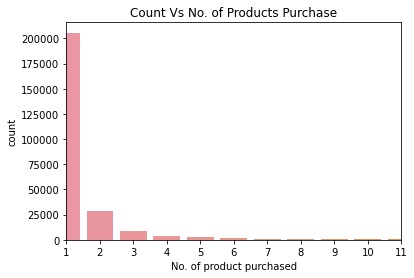

In [50]:
sns.countplot(purchase["No. of product purchased"])
plt.xlim(0,10)
plt.title("Count Vs No. of Products Purchase")
plt.show()

In [51]:
purchase.describe()

No. of product purchased
count             256059.000000
mean                   1.538446
std                    2.756584
min                    1.000000
25%                    1.000000
50%                    1.000000
75%                    1.000000
max                  329.000000

### Observation:
#### 1. Maximum customers purchase only 1 product

# Analysis on Helpfulness

In [52]:
# Helpfulness Numerator(helpfull) - No. of customers who find review helpful
# Helpfulness Denominator(helpfull + not helpfull) -  Number of users who indicated whether they found the review helpful or not
# Helpfulness Numerator > Helpfulness Denominator ---> is not practically possible

reviews[reviews["HelpfulnessNumerator"]>reviews["HelpfulnessDenominator"]]

Id   ProductId          UserId              ProfileName  \
44736  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   
64421  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   

       HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
44736                     3                       2      1  1212883200   
64421                     3                       1      1  1224892800   

                                            Summary  \
44736  Pure cocoa taste with crunchy almonds inside   
64421             Bought This for My Son at College   

                                                    Text       Date  
44736  It was almost a 'love at first bite' - the per... 2008-06-08  
64421  My son loves spaghetti so I didn't hesitate or... 2008-10-25

In [53]:
# we will drop this row from review dataset

reviews = reviews[reviews["HelpfulnessNumerator"]<=reviews["HelpfulnessDenominator"]]
reviews.shape

(393931, 11)

# Text Preprocessing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

In [54]:
# remove html tags
from bs4 import BeautifulSoup

sent_12000 = reviews["Text"].values[12000]
print(sent_12000)
soup = BeautifulSoup(sent_12000, 'lxml')
print("________________________________________________________________________________________________")
text = soup.get_text()
print(text)

I was very excited to get this product as I used to love their toasted pumpkin seed oil. Unfortunately I couldn't taste the pistachio flavor. So because of the price & lack of taste, I wouldn't purchase it again.<br /><br />Great company though. Michael is a great guy.<br /><br />Michelle
________________________________________________________________________________________________
I was very excited to get this product as I used to love their toasted pumpkin seed oil. Unfortunately I couldn't taste the pistachio flavor. So because of the price & lack of taste, I wouldn't purchase it again.Great company though. Michael is a great guy.Michelle


In [55]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
import re
sent_100 = reviews["Text"].values[100]
print(sent_100)
print("________________________________________________________________________________________________")
sent_100 = re.sub(r"http\S+", "", sent_100)
print(sent_100)

Arrived slightly thawed. My parents wouldn't accept it. However, the company was very helpful and issued a full refund.
________________________________________________________________________________________________
Arrived slightly thawed. My parents wouldn't accept it. However, the company was very helpful and issued a full refund.


In [56]:
# Decontraction of text
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [57]:
sent_15000 = reviews["Text"].values[15000]
print(sent_15000)
print("________________________________________________________________________________________________")
sent_15000 = decontracted(sent_15000)
print(sent_15000)

This product is a real bargain, considering the fact that dogs love liver. I've used this as an addition to another dog treat product I use for my dog. My dog goes nuts when he knows that he's about to be rewarded with<br />Pro-Treat Beef Liver treats. The instructions advise to give 2-3 pieces per day when using. At this rate, the container will last you a good while. The product itself is very fresh and the pieces are all of various sizes and thickness. Average size of treat is small rectangular pieces of different thickness. They're easy to break into smaller pieces if necessary. My Springer Spaniel pup is 5 months old and he just loves these. I tried this product on my girlfriend's 10 yr old teacup Poodle, who is pretty slow at this point in her life. She absolutely came to life and jumped all over the place for a taste of one of these treats. Buy it....your dog will love it!
________________________________________________________________________________________________
This produ

In [58]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_15000 = reviews["Text"].values[15000]
print(sent_15000)
print("________________________________________________________________________________________________")
sent_15000 = re.sub("\S*\d\S*", "", sent_15000).strip()
print(sent_15000)

This product is a real bargain, considering the fact that dogs love liver. I've used this as an addition to another dog treat product I use for my dog. My dog goes nuts when he knows that he's about to be rewarded with<br />Pro-Treat Beef Liver treats. The instructions advise to give 2-3 pieces per day when using. At this rate, the container will last you a good while. The product itself is very fresh and the pieces are all of various sizes and thickness. Average size of treat is small rectangular pieces of different thickness. They're easy to break into smaller pieces if necessary. My Springer Spaniel pup is 5 months old and he just loves these. I tried this product on my girlfriend's 10 yr old teacup Poodle, who is pretty slow at this point in her life. She absolutely came to life and jumped all over the place for a taste of one of these treats. Buy it....your dog will love it!
________________________________________________________________________________________________
This produ

In [59]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
import re
sent_1500 = reviews["Text"].values[1500]
print(sent_1500)

my_sent = "munira_fatima846@gmail.com"
print("________________________________________________________________________________________________")
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', my_sent)
print(sent_1500)

When my daughter was an infant, she was allergic to something in my breastmilk and was put on Neocate which worked wonders for her allergic colitis.  For my son, we were therefore very careful when it came time to picking out a formula to supplement breastmilk.  His stomach does react when I have accidentally had more dairy than I can tolerate so my pediatrician recommended a lactose free formula, especially given our Asian background.  I wanted something organic, not soy, lactose free, and with as clean of a label as possible and this formula fulfills all of those criteria.  My son didn't like it at first, but now he switches easily between breastmillk and formula.  He has not been gassy nor spit up on it.  I really wish Amazon stocked it.
________________________________________________________________________________________________
munira fatima846 gmail com


In [60]:
from wordcloud import STOPWORDS

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords = set(STOPWORDS)
print(stopwords)

{"i've", 'when', 'also', 'a', "when's", 'no', 'other', 'is', 'k', 'up', 'do', "hadn't", "what's", 'into', 'of', "aren't", 'who', 'about', 'get', 'ourselves', "won't", 'yourself', 'any', 'would', 'over', 'them', 'has', 'in', 'how', 'while', 'an', "he's", 'to', 'her', "who's", 'just', 'these', 'hers', "hasn't", "i'd", 'or', 'be', 'are', 'with', 'only', "we've", 'com', 'why', 'by', 'once', 'each', 'until', 'you', 'yourselves', "he'd", "you've", 'down', "he'll", "how's", "shouldn't", 'some', 'for', "they're", "they'll", 'further', 'she', 'that', 'me', 'because', 'all', 'before', 'he', "they've", 'having', 'was', 'else', 'ours', 'cannot', 'both', "there's", 'through', 'http', "she'll", "shan't", 'doing', "wouldn't", 'same', 'so', "haven't", "here's", 'under', 'it', 'then', "couldn't", 'more', 'but', 'i', 'his', 'if', 'what', 'however', "you'd", 'we', 'below', 'which', 'not', 'www', 'yours', 'those', 'from', "weren't", 'were', 'very', 'they', "wasn't", 'my', 'can', 'did', "she's", 'therefore

In [61]:
# Combining all the above preprocessing 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(reviews['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())


  0%|                                                                                       | 0/393931 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

100%|████████████████████████████████████████████████████████████████████████| 393931/393931 [02:53<00:00, 2274.41it/s]


In [62]:
reviews["Clean_Text"] = preprocessed_reviews
reviews.head(2)

Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      1  1303862400  Good Quality Dog Food   
1                       0      0  1346976000      Not as Advertised   

                                                Text       Date  \
0  I have bought several of the Vitality canned d... 2011-04-27   
1  Product arrived labeled as Jumbo Salted Peanut... 2012-09-07   

                                          Clean_Text  
0  bought several vitality canned dog food produc...  
1  product arrived labeled jumbo salted peanuts p...

In [63]:
final_df = reviews[["Time","Clean_Text","Score"]]
final_df.head(2)

Time                                         Clean_Text  Score
0  1303862400  bought several vitality canned dog food produc...      1
1  1346976000  product arrived labeled jumbo salted peanuts p...      0

In [64]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393931 entries, 0 to 568453
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Time        393931 non-null  int64 
 1   Clean_Text  393931 non-null  object
 2   Score       393931 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 12.0+ MB


In [65]:
final_df = final_df.dropna(axis=0)
final_df.shape

(393931, 3)

In [66]:
#sorting based on time
final_df['Time'] = pd.to_datetime(final_df['Time'],unit='s')
final_df = final_df.sort_values('Time')
final_df = final_df.reset_index(drop=True)
final_df.head(3)

Time                                         Clean_Text  Score
0 1999-10-08  witty little book makes son laugh loud recite ...      1
1 1999-10-25  remember seeing show aired television years ag...      1
2 1999-12-02  beetlejuice well written movie everything exce...      1

# Splitting Dataset into train and test

In [67]:
from sklearn.model_selection import train_test_split
x = final_df["Clean_Text"]
y = final_df["Score"]
x.shape

(393931,)

In [68]:
y.shape

(393931,)

In [69]:
x_train, x_test,y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state = 30, stratify = y)
x_train.shape, y_train.shape

((275751,), (275751,))

In [70]:
x_test.shape , y_test.shape

((118180,), (118180,))

# Important Note:

1. You should always try to fit your model on train data and transform it on test data. 
2. Do not try to fit your vectorizer on test data as it can cause data leakage issues.

# Convert Text into vector

### Bag of words

In [84]:
from sklearn.feature_extraction.text import CountVectorizer

In [99]:
# ngram_range = (1,2)
bow = CountVectorizer()
bow.fit(x_train)
x_train_bow = bow.transform(x_train)
x_test_bow = bow.transform(x_test)

In [88]:
bow_features = bow.get_feature_names()
print(bow_features[0:10])

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa']


In [89]:
print(x_train_bow.shape, x_test_bow.shape)

(275751, 101349) (118180, 101349)


# Tfidf

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [91]:
tfidf = TfidfVectorizer()
tfidf.fit(x_train)
x_train_tfidf = tfidf.transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

tfidf_features = tfidf.get_feature_names()
print(tfidf_features[0:10])

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa']


In [92]:
print(np.array(tfidf_features))

['aa' 'aaa' 'aaaa' ... 'zzzzzzz' 'zzzzzzzz'
 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz']


In [93]:
print(x_train_tfidf.shape, x_test_tfidf.shape)

(275751, 101349) (118180, 101349)


# Word2Vec

In [94]:
from gensim.models import Word2Vec

In [95]:
preprocess_reviews = x_train.values
train_sentence = [review.split() for review in preprocess_reviews]
# min_count = 5 considers only words that occured atleast 5 times
# size = length of vector
w2v_model_train = Word2Vec(train_sentence,min_count=5,vector_size=50, workers=4)
# w2v_model_train.wv.vocab
w2v_words = list(w2v_model_train.wv.key_to_index)

In [96]:
print(w2v_words[0:10])

['good', 'will', 'taste', 'one', 'great', 'product', 'flavor', 'coffee', 'tea', 'love']


# Saving Vectors

In [97]:
# saving bow vector
import pickle
pickle.dump(x_train_bow, open("saved_feats/X_train_bow","wb"))
pickle.dump(x_test_bow, open("saved_feats/X_test_bow","wb"))
pickle.dump(np.array(bow_features), open("saved_feats/bow_features","wb"))

FileNotFoundError: [Errno 2] No such file or directory: 'saved_feats/X_train_bow'

In [ ]:
#saving tfidf vectors
pickle.dump(X_train_tfidf, open("saved_feats/X_train_tfidf","wb"))
pickle.dump(X_test_tfidf, open("saved_feats/X_test_tfidf","wb"))
pickle.dump(np.array(tfidf_features), open("saved_feats/tfidf_features","wb"))

In [ ]:
# saving word2vec vector
pickle.dump(np.array(w2v_words),open("saved_feats/w2v_words","wb"))

# Loading Saved Vectors

In [ ]:
# loading bow vectors
X_train_bow = pickle.load(open("saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("saved_feats/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("saved_feats/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("saved_feats/tfidf_features","rb")).tolist()
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))

#Loading w2v vectors
w2v_words = pickle.load(open("saved_feats/w2v_words","rb")).tolist()

# Naive Bayes on Bag of Words

In [100]:
train_auc = []
cv_auc = []
alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for param in alpha:
    naive = MultinomialNB(alpha=param)
    naive.fit(X_train_bow,y_tr)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    y_train_pred =  naive.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  naive.predict_proba(X_cv_bow)[:,1] 
    train_auc.append(roc_auc_score(y_tr,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
#plotting
plt.grid(True)
plt.plot(np.log(alpha), train_auc, label='Train AUC')
plt.plot(np.log(alpha), cv_auc, label='CV AUC')
plt.scatter(np.log(alpha), train_auc)
plt.scatter(np.log(alpha), cv_auc)
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

NameError: name 'X_train_bow' is not defined

In [ ]:
from sklearn.metrics import roc_curve, auc
optimal_alpha = 0.1
naive_opt = MultinomialNB(alpha=optimal_alpha)
naive_opt = naive_opt.fit(X_train_bow,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, naive_opt.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, naive_opt.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(naive_opt,X_train_bow,y_tr,X_test_bow,y_test)

In [ ]:
import random

In [ ]:
alpha = np.random.randint(0.001,1000,5)
acc_dict = {}
for param in alpha:
    naive = MultinomialNB(alpha = param)
    naive.fit(x_train,y_train)
    y_pred = naive.predict(x_test)
    acc = accuracy(y_pred,y_test)
    acc_dict["param"] = acc
print(acc_dict)

In [ ]:
{"219" : 0.98898989,
"431": 0.7889898,
"902": 0.999999,
"311": 0.989898,
"940": 0.989898}

In [ ]:
from sklearn.model_selection import train_test_split
x = df["review"]
y = df["score"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, stratify = y, random_state = 20)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)